# Introduction to TensorFlow

```{admonition} Attribution
The following notebook follows Chapter 13 of {cite}`RaschkaMirjalili2019`.
```

**TensorFlow** is a scalable and multiplatform programming interface for implementing 
and running machine learning algorithms, including convenience wrappers for 
deep learning. TensorFlow was initially built by the researchers and engineers from 
the Google Brain team for internal use, but it was subsequently released in November 2015 under a permissive open source license. Many machine learning researchers and practitioners from academia and industry have adapted TensorFlow to develop deep learning solutions.


## How we will learn TF

Refer to Introduction to Pytorch (notebook link) for a discussion of tensors, GPUs (and how it improves neural network training performance by allowing parallelized floating point computation), gradients, and so on. In this notebook, we proceed to the practical application of Tensorflow.

First, we are going to cover TensorFlow's programming model, in particular, 
creating and manipulating tensors. Then, we will see how to load data and utilize 
TensorFlow Dataset objects, which will allow us to iterate through a dataset 
efficiently. In addition, we will discuss the existing, ready-to-use datasets in the 
tensorflow_datasets submodule and learn how to use them.
After learning about these basics, the `tf.keras` API will be introduced and we will 
move forward to building machine learning models, learn how to compile and train 
the models, and learn how to save the trained models on disk for future evaluation

## First steps with TensorFlow

```{margin}
**Installation**
```

In case you want to use GPUs (recommended), you need a compatible NVIDIA 
graphics card, along with the CUDA Toolkit and the NVIDIA cuDNN library to be 
installed. If your machine satisfies these requirements, you can install TensorFlow 
with GPU support, as follows:

```pip install tensorflow-gpu```

In [1]:
import tensorflow as tf

tf.random.set_seed(42)
print(tf.__version__)

2.6.2


### Creating tensors in TensorFlow

Now, let's consider a few different ways of creating tensors, and then see some of 
their properties and how to manipulate them. Firstly, we can simply create a tensor 
from a list or a NumPy array using the tf.convert_to_tensor function as follows:

In [2]:
import numpy as np

a = np.arange(3, dtype=np.int32)
b = [0, 1, 2]

t_a = tf.convert_to_tensor(a)
t_b = tf.convert_to_tensor(b)

print(t_a)
print(t_b)

tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([0 1 2], shape=(3,), dtype=int32)



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

We can initialize tensors with specific structure, e.g. full of ones:

In [3]:
t = tf.ones((2, 3))

In [4]:
t.shape

TensorShape([2, 3])

In [5]:
t.numpy()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

To initialize non-trainable parameters, we initialize the tensor using `tf.constant` (this is equivalent to setting `requires_grad = False` in PyTorch). 

In [6]:
tf.constant([-1.0, np.pi])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.       ,  3.1415927], dtype=float32)>

### Manipulating the data type and shape of a tensor

Learning ways to manipulate tensors is necessary to make them compatible for input 
to a model or an operation. In this section, you will learn how to manipulate tensor 
data types and shapes via several TensorFlow functions that cast, reshape, transpose, 
and squeeze.

In [7]:
t_a_new = tf.cast(t_a, tf.int64)
print(t_a.dtype)
print(t_a_new.dtype)

<dtype: 'int32'>
<dtype: 'int64'>


As you will see in upcoming chapters, certain operations require that the input 
tensors have a certain number of dimensions (that is, **rank**) associated with 
a certain number of elements (shape). Thus, we might need to change the shape 
of a tensor, add a new dimension, or squeeze an unnecessary dimension. TensorFlow 
provides useful functions (or operations) to achieve this, such as `tf.transpose()`, 
`tf.reshape()`, and `tf.squeeze()`. Let's take a look at some examples:

**Transposing a tensor:**

In [8]:
t = tf.random.uniform(shape=(3, 5))
t_tr = tf.transpose(t)
print(t.shape, " -> ", t_tr.shape)

(3, 5)  ->  (5, 3)


**Reshaping a tensor** (e.g. rank 1 to rank 2):

In [9]:
t = tf.zeros(30)
print(tf.reshape(t, (5, 6)))

tf.Tensor(
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]], shape=(5, 6), dtype=float32)


**Removing the unnecessary dimensions**:

In [10]:
t = tf.zeros(shape=(1, 1, 5)) # specify which axis to squeeze out
t_sqz = tf.squeeze(t, axis=[0, 1])
print(t.shape, ' -> ', t_sqz.shape)

(1, 1, 5)  ->  (5,)


In [11]:
print(t)
print(t_sqz)

tf.Tensor([[[0. 0. 0. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)


### Applying mathematical operations to tensors

Applying mathematical operations, in particular linear algebra operations, is 
necessary for building most machine learning models. In this subsection, we will 
cover some widely used linear algebra operations, such as element-wise product, 
matrix multiplication, and computing the norm of a tensor.

**Element-wise product.** We can compute element-wise product of two tensors with the same shape using `tf.multiply`:

In [12]:
t1 = tf.random.uniform(shape=(5, 2), minval=-1.0, maxval=1.0) # U[-1, 1)
t2 = tf.random.normal(shape=(5, 2), mean=0.0, stddev=1.0)

# element-wise multiplication
t3 = tf.multiply(t1, t2)
print(t3.numpy())

[[-0.210099    0.016599  ]
 [ 2.0455282   0.779418  ]
 [ 0.3723916  -0.6547072 ]
 [ 0.27351022  1.1300068 ]
 [-0.0861173  -0.14660712]]


**Reduction.** To compute the mean, sum, and standard deviation along a certain axis (or axes), we can use `tf.math.reduce_mean()`, `tf.math.reduce_sum()`, and `tf.math.reduce_
std()`. For example, the mean of each column in `t1` can be computed as follows:

In [13]:
_ = tf.math.reduce_mean(t1, axis=0) # "collapse" axis zero -> vector along column
print(_)
print(t1.shape, ' -> ', _.shape)

tf.Tensor([0.45841765 0.17030029], shape=(2,), dtype=float32)
(5, 2)  ->  (2,)


**Matrix product.** Matrix product between tensors can be computed using  the `tf.linalg.matmul()` function 
as follows. Here we compute the matrix products $\mathbf{t}_1 {\mathbf{t}_2}^\top \in \mathbb R^{5 \times 5}$ and ${\mathbf{t}_1}^\top {\mathbf{t}_2} \in \mathbb R^{2 \times 2}.$

In [14]:
_ = tf.linalg.matmul(t1, t2, transpose_b=True)
print(_.numpy())

[[-0.1935      0.94056135  0.32858038  0.04468814  0.1555669 ]
 [-0.21691385  2.8249462   1.1076279  -0.85924757  1.0162319 ]
 [-0.6783044  -0.13762808 -0.28231558  1.9206761  -1.0877459 ]
 [-0.76620007  1.3360949   0.3038885   1.403517   -0.5195191 ]
 [ 0.11810179 -0.86383766 -0.32153872  0.12154704 -0.23272441]]


In [15]:
_ = tf.linalg.matmul(t1, t2, transpose_a=True)
print(_.numpy())

[[ 2.3952138   0.55109847]
 [-0.34674644  1.1247094 ]]


**Tensor norm.** Finally, the `tf.norm()` function is useful for computing the ${L}^p$ norm of a tensor. 
For example, we can calculate the ${L}^2$ norm of `t1` as follows:

In [16]:
print(tf.norm(t1))

tf.Tensor(1.7629007, shape=(), dtype=float32)


In [17]:
print(tf.sqrt(tf.reduce_sum(tf.reshape(tf.multiply(t1, t1), 10))))

tf.Tensor(1.7629007, shape=(), dtype=float32)


### Split, stack, and concatenate tensors

In this subsection, we will cover TensorFlow operations for splitting a tensor into 
multiple tensors, or the reverse: stacking and concatenating multiple tensors into 
a single one.

**Split.** Assume that we have a single tensor and we want to split it into two or more tensors. 
For this, TensorFlow provides a convenient `tf.split()` function, which divides 
an input tensor into a list of equally-sized tensors.

In [18]:
t = tf.random.uniform(shape=[10, 3])
print(t)

tf.Tensor(
[[0.7402308  0.33938193 0.5692506 ]
 [0.44811392 0.29285502 0.4260056 ]
 [0.62890387 0.691061   0.30925727]
 [0.89236605 0.66396606 0.30541587]
 [0.8724164  0.1025728  0.56819403]
 [0.25427842 0.7253866  0.4770788 ]
 [0.46289814 0.88944995 0.6792555 ]
 [0.09752727 0.01609659 0.4876021 ]
 [0.5832968  0.41212583 0.731905  ]
 [0.93418944 0.5298122  0.9664817 ]], shape=(10, 3), dtype=float32)


In [19]:
tf.split(t, num_or_size_splits=2, axis=0) # num splits (int)

[<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[0.7402308 , 0.33938193, 0.5692506 ],
        [0.44811392, 0.29285502, 0.4260056 ],
        [0.62890387, 0.691061  , 0.30925727],
        [0.89236605, 0.66396606, 0.30541587],
        [0.8724164 , 0.1025728 , 0.56819403]], dtype=float32)>,
 <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[0.25427842, 0.7253866 , 0.4770788 ],
        [0.46289814, 0.88944995, 0.6792555 ],
        [0.09752727, 0.01609659, 0.4876021 ],
        [0.5832968 , 0.41212583, 0.731905  ],
        [0.93418944, 0.5298122 , 0.9664817 ]], dtype=float32)>]

In [20]:
tf.split(t, num_or_size_splits=[8, 2], axis=0) # size splits (List[int])

[<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
 array([[0.7402308 , 0.33938193, 0.5692506 ],
        [0.44811392, 0.29285502, 0.4260056 ],
        [0.62890387, 0.691061  , 0.30925727],
        [0.89236605, 0.66396606, 0.30541587],
        [0.8724164 , 0.1025728 , 0.56819403],
        [0.25427842, 0.7253866 , 0.4770788 ],
        [0.46289814, 0.88944995, 0.6792555 ],
        [0.09752727, 0.01609659, 0.4876021 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[0.5832968 , 0.41212583, 0.731905  ],
        [0.93418944, 0.5298122 , 0.9664817 ]], dtype=float32)>]

**Concat and stack.** Sometimes, we are working with multiple tensors and need to concatenate or stack 
them to create a single tensor. In this case, TensorFlow functions such as `tf.stack()`
and `tf.concat()` come in handy. Note that concatenating joins a sequence of tensors along an existing axis, while stacking joins a sequence of tensors along a new axis.


In [21]:
u = tf.ones(3,)
v = tf.zeros(3,)

tf.concat([u, v], axis=0)

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 0.], dtype=float32)>

In [22]:
tf.stack([u, v], axis=0)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [0., 0., 0.]], dtype=float32)>

In [23]:
tf.stack([u, v], axis=1)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

## Building input pipelines using `tf.data` – the TensorFlow Dataset API

```{margin}
Note that these are all analogous to the `Dataset` and `DataLoader` API of PyTorch.
```

When we are training a deep NN model, we usually train the model using SGD and its variants. 
In cases where the training dataset is small and can 
be loaded as a tensor into the memory, TF models (that are built with the 
Keras API) can be trained directly with this dataset tensor via their `.fit()` method. In 
typical use cases, however, the dataset is too large to fit into the computer 
memory, and we will need to load the data from the main storage device in chunks. In addition, we may need to construct a data-processing 
pipeline to apply certain transformations and preprocessing steps to our data. Applying preprocessing functions manually every time can be quite cumbersome. TensorFlow provides a special class for constructing efficient and convenient preprocessing pipelines.

In this section, we will see an overview of different methods for constructing a TensorFlow `Dataset` including dataset transformations and common preprocessing steps for images and tabular data.

### Creating a TensorFlow Dataset from existing tensors

In [24]:
a = tf.range(10)
ds = tf.data.Dataset.from_tensor_slices(a)
print(ds)

<TensorSliceDataset shapes: (), types: tf.int32>


In [25]:
for item in ds:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [26]:
ds_batch = ds.batch(4, drop_remainder=False) # Analogous to drop_last in PyTorch
for batch in ds_batch:
    print(batch)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


### Combining two tensors into a joint dataset

In [27]:
import pandas as pd

X = tf.random.uniform([10, 3], dtype=tf.float32)
y = tf.range(10)

feature_set = tf.data.Dataset.from_tensor_slices(X)
label_set   = tf.data.Dataset.from_tensor_slices(y)

ds_joint = tf.data.Dataset.zip((feature_set, label_set))
for x, t in ds_joint.batch(4):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  0.803156  0.497777  0.370540  0
1  0.911867  0.637642  0.182097  1
2  0.637920  0.277015  0.042271  2
3  0.842194  0.906372  0.222556  3 

         X1        X2        X3  y
0  0.919846  0.687891  0.427052  4
1  0.878158  0.694396  0.465676  5
2  0.529258  0.330190  0.127549  6
3  0.161535  0.508514  0.443018  7 

         X1        X2        X3  y
0  0.352059  0.896915  0.249408  8
1  0.763283  0.859358  0.084802  9 



Alternatively, we could have started with the raw tensors:

In [28]:
ds_joint = tf.data.Dataset.from_tensor_slices((X, y))
print(ds_joint)

<TensorSliceDataset shapes: ((3,), ()), types: (tf.float32, tf.int32)>


### Transformations

We can also apply transformations to each individual element of the dataset.

In [29]:
X_max = tf.reduce_max(X, axis=0)
X_min = tf.reduce_min(X, axis=0)
df_transformed = ds_joint.map(lambda x, y: (tf.math.divide(x - X_min, X_max - X_min), y))
for x, t in df_transformed.batch(4):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  0.846118  0.350775  0.775308  0
1  0.989478  0.573009  0.330241  1
2  0.628218  0.000000  0.000000  2
3  0.897598  1.000000  0.425798  3 

         X1        X2        X3  y
0  1.000000  0.652850  0.908777  4
1  0.945025  0.663186  1.000000  5
2  0.484923  0.084492  0.201409  6
3  0.000000  0.367834  0.946486  7 

         X1        X2        X3  y
0  0.251247  0.984973  0.489217  8
1  0.793537  0.925298  0.100449  9 



2021-12-13 10:15:39.546367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Applying this sort of transformation can be used for a user-defined function. 
For example, if we have a dataset created from the list of image filenames on disk, 
we can define a function to load the images from these filenames and apply that 
function by calling the `.map()` method. 

### Shuffle, batch, and repeat

To train an NN model using stochastic gradient descent optimization, 
it is important to feed training data as randomly shuffled batches. This [answer](https://stackoverflow.com/a/47025850) in SO provides a good explanation for `buffer_size`:

> [`Dataset.shuffle()` is designed] to handle datasets that are too large to fit in memory. Instead of shuffling the entire dataset, it maintains a buffer of `buffer_size` elements, and randomly selects the next element from that buffer (replacing it with the next input element, if one is available). <br><br>
Changing the value of `buffer_size` affects how uniform the shuffling is: if `buffer_size` is greater than the number of elements in the dataset, you get a uniform shuffle; if it is 1 then you get no shuffling at all. For very large datasets, a typical "good enough" approach is to randomly shard the data into multiple files once before training, then shuffle the filenames uniformly, and then use a smaller shuffle buffer. However, the appropriate choice will depend on the exact nature of your training job.

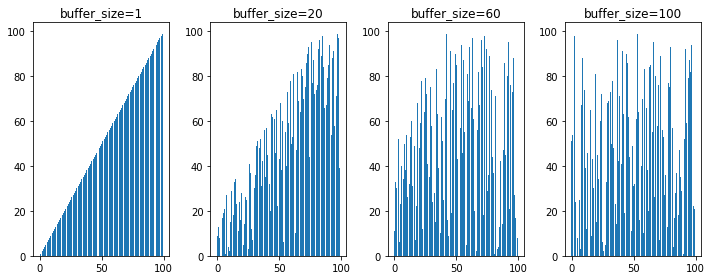

In [30]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(10, 4))
buffer_size = [1, 20, 60, 100]
for i in range(len(buffer_size)):
    shuffled_data = []
    ds_range = tf.data.Dataset.from_tensor_slices(tf.range(100))
    for x in ds_range.shuffle(buffer_size[i]).batch(1):
        shuffled_data.append(x.numpy()[0])

    ax = fig.add_subplot(1, 4, i+1)
    ax.bar(range(100), shuffled_data)
    ax.set_title(f"buffer_size={buffer_size[i]}")

plt.tight_layout()
plt.show()


When training a model for multiple epochs, we need to shuffle and iterate over the dataset by the desired number of epochs. To repeat the dataset, we use the `.repeat` method on the dataset object. The following pattern repeats the dataset, shuffles it, then partitions the dataset into batches:

In [31]:
buffer_size = 6
for x, t in df_transformed.repeat(2).shuffle(buffer_size).batch(4):
    print(pd.DataFrame(
            {
                'X1': x.numpy()[:, 0],
                'X2': x.numpy()[:, 1], 
                'X3': x.numpy()[:, 2], 
                'y': t.numpy()
            }
        ), '\n'
    )

         X1        X2        X3  y
0  0.846118  0.350775  0.775308  0
1  0.628218  0.000000  0.000000  2
2  0.484923  0.084492  0.201409  6
3  0.897598  1.000000  0.425798  3 

         X1        X2        X3  y
0  0.251247  0.984973  0.489217  8
1  1.000000  0.652850  0.908777  4
2  0.846118  0.350775  0.775308  0
3  0.000000  0.367834  0.946486  7 

         X1        X2        X3  y
0  0.793537  0.925298  0.100449  9
1  0.989478  0.573009  0.330241  1
2  1.000000  0.652850  0.908777  4
3  0.484923  0.084492  0.201409  6 

         X1        X2        X3  y
0  0.945025  0.663186  1.000000  5
1  0.000000  0.367834  0.946486  7
2  0.897598  1.000000  0.425798  3
3  0.989478  0.573009  0.330241  1 

         X1        X2        X3  y
0  0.251247  0.984973  0.489217  8
1  0.945025  0.663186  1.000000  5
2  0.628218  0.000000  0.000000  2
3  0.793537  0.925298  0.100449  9 



### Creating a dataset from files on your local storage disk

We can get filenames using `.glob` on a `pathlib.Path` object as follows:

In [32]:
import pathlib
import os

cat_imgdir_path = pathlib.Path("../input/cat2dog/cat2dog/trainA")
dog_imgdir_path = pathlib.Path("../input/cat2dog/cat2dog/trainB")

cat_file_list = sorted([str(path) for path in cat_imgdir_path.glob("*.jpg")])
dog_file_list = sorted([str(path) for path in dog_imgdir_path.glob("*.jpg")])

Visualizing image sets for cats and dogs:

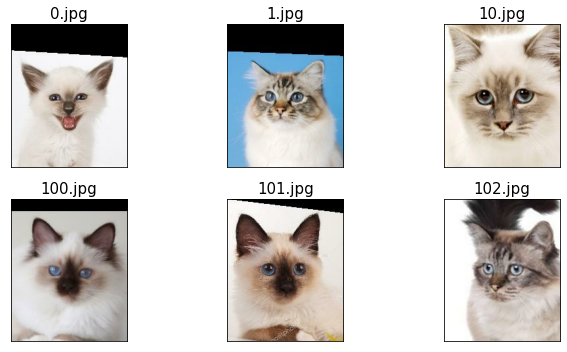

In [33]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(cat_file_list[:6]):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(pathlib.Path(file).name, size=15)
    
plt.tight_layout()
plt.show()

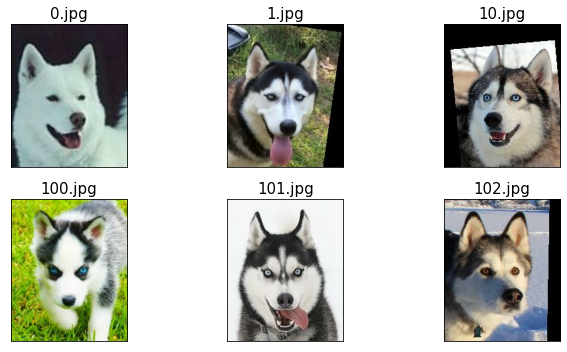

In [34]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(dog_file_list[:6]):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(pathlib.Path(file).name, size=15)
    
plt.tight_layout()
plt.show()

Instead of having a dataset of arrays for images, and their corresponding labels, we can create a dataset of filenames and their labels. Then, we can transform the filenames to images using a mapping to load and preprocess images given their filenames.

0


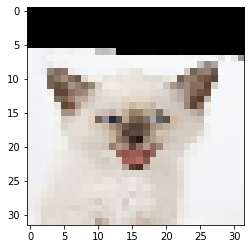

In [35]:
from functools import partial

# Define mapping function: (filename, label) -> (RGB array, label)
def load_and_preprocess(path, label, img_width=124, img_height=124):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img /= 255.0
    return img, label

# Create dataset of RGB arrays resized to 32x32x3
filenames = cat_file_list + dog_file_list
labels = [0] * len(cat_file_list) + [1] * len(dog_file_list)
filenames_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
images_dataset = filenames_dataset.map(partial(load_and_preprocess, img_width=32, img_height=32))

# Display one image and its label (0 = cat, 1 = dog) 
img, label = next(iter(images_dataset.batch(1)))
print(label.numpy()[0])
plt.imshow(img[0, :, :, :]);

### Fetching available datasets from the `tensorflow_datasets` library

The `tensorflow_datasets` library provides a nice collection of freely available 
datasets for training or evaluating deep learning models. The datasets are nicely 
formatted and come with informative descriptions, including the format of features 
and labels and their type and dimensionality, as well as the citation of the original 
paper that introduced the dataset in BibTeX format. Another advantage is that these 
datasets are all prepared and ready to use as `tf.data.Dataset` objects, so all the 
functions we covered in the previous sections can be used directly.

In [36]:
import tensorflow_datasets as tfds

print(len(tfds.list_builders())) # no. of available datasets
print(tfds.list_builders()[:5])

881
['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']


2021-12-13 10:15:45.533498: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


The book outlines two ways of loading datasetes from `tfds`. The first approach consists of three steps:
1. Calling the dataset builder function
2. Executing the `download_and_prepare()` method
3. Calling the `as_dataset()` method